In [1]:
"""
ポケモン画像とタイプデータに対して多クラス分類を行う。
dataset.py からデータをロードし、モデルに合わせて学習データを生成する。
モデルを構築し、学習を行う。結果の可視化を行う。
"""
#TensorFloは、機械学習や深層学習のプログラムを実装する際に使用できるライブラリ
import keras
import tensorflow as tf
import dask
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
import dataset
import dataset2
import random

#データのロード
X,Z = dataset.load_data() #画像データ
Y = dataset2.Data_set() #タイプデータ

import numpy as np
import matplotlib.pyplot as plt

#タイプのラベル
pokemon_labels = np.array([
    "Normal", "Fire", "Water", "Electric", "Grass", "Ice", "Fighting",
    "Poison", "Ground", "Flying", "Psychic", "Bug", "Rock", "Ghost", "Dragon",
    "Dark", "Steel", "Fairy"
])

#X:画像データ
#Y:Type1とType2のデータ

#Type1のみ取得
y1 = Y[0]

#Type2のみ取得
y2 = Y[1]

#トレインデータとテストデータの生成
x_train = X[0:801] 
y1_train = y1[0:801]
y2_train = y2[0:801]
x_test = X[801:] #第8世代のデータ(画像)
y1_test = y1[801:] #第8世代のデータ(type1)
y2_test = y2[801:] #第8世代のデータ(type2)

img_rows = 64
img_cols = 64 #モデルに入力する画像の横と縦の幅を64に設定
img_channels = 4 #モデルに入力する画像のチャンネル数

# 画像データは0～255の値をとるので255で割ることでデータを標準化する
# .astype('float32')でデータ型を変換する。(しないと割ったときにエラーが出るはず)
X_train = x_train.astype('float32') / 255.
X_test = x_test.astype('float32') / 255.

y1_train = list(y1_train) #シャッフルするために一旦リスト型に変換
y2_train = list(y2_train)
for i in (X_train, y1_train, y2_train):
    random.seed(0)
    random.shuffle(i)

y1_train = tuple(y1_train) #タプル型に戻す
y2_train = tuple(y2_train)

nb_classes = 18 # 正解のパターン数

/Users/e175750/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


loading images ... 882/882 done
loading types data ... done


In [2]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y2_train = np_utils.to_categorical(y2_train, nb_classes)
Y2_test = np_utils.to_categorical(y2_test, nb_classes)
print(Y2_train.shape)
print(Y2_test.shape)

(801, 18)
(81, 18)


In [3]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K

#KerasのバックエンドがTheano(channels_first)か tensorflow(channels_last)かで画像の書式が異なる
#K.image_data_format()は"channels_last" か "channels_first" のいずれかを返すので、これに従って場合分けする
#白黒の場合はチャンネル数は1になる。RGBのカラー画像であればチャンネル数は3になる
#今回はx_train：(60000, 28, 28)->(60000, 28, 28, 1)になる

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print(X_train.shape)
print(X_test.shape)

(801, 64, 64, 4)
(81, 64, 64, 4)


In [4]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.15))
model.add(Dense(18, activation='softmax'))

/Users/e175750/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 801 samples, validate on 81 samples
Epoch 1/3
801/801 [==============================] - 118s 148ms/step - loss: 14.4223 - acc: 0.0749 - val_loss: 15.1232 - val_acc: 0.0617
Epoch 2/3
801/801 [==============================] - 113s 141ms/step - loss: 14.8303 - acc: 0.0799 - val_loss: 15.1232 - val_acc: 0.0617
Epoch 3/3
801/801 [==============================] - 131s 163ms/step - loss: 14.8303 - acc: 0.0799 - val_loss: 15.1232 - val_acc: 0.0617
Test score: 15.123150919690545
Test accuracy: 0.06172839510771963


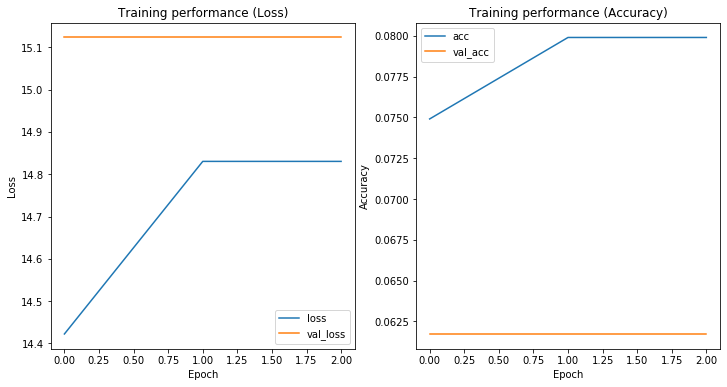

In [5]:
#type2(801) to type2(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y2_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y2_test))

score1 = model.evaluate(X_test, Y2_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

10
4
10
4
10
4
10
1
10
1
10
1
10
2
10
2
10
2
10
11
10
10


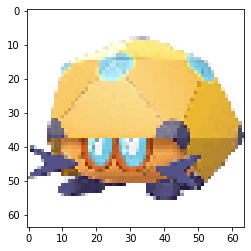

10
10


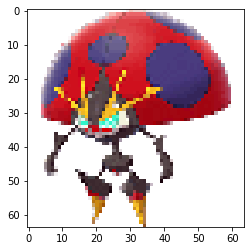

10
9
10
9
10
16
10
0
10
0
10
15
10
15
10
0
10
0
10
0
10
2
10
12
10
3
10
3
10
4
10
4
10
11
10
11
10
12
10
1
10
1
10
2
10
2
10
16
10
17
10
17
10
14
10
14
10
14
10
6
10
13
10
17
10
17
10
17
10
10


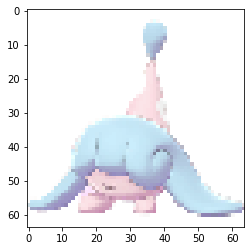

10
10


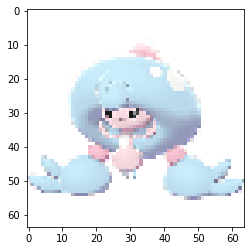

10
17
10
16
10
16
10
2
10
7
10
7
10
8
10
8
10
13
10
13
10
13
10
0
10
15
10
6
10
11
10
11
10
6
10
6
10
3
10
10


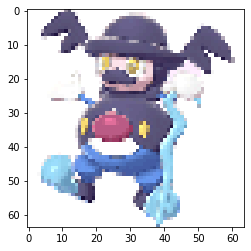

10
12
10
5
10
14
10
14
10
5
10
14
10
5
10
13
10
13
10
13
10
16
10
16
10
14
5


'\nfig = plt.figure(figsize=(15, 85), facecolor="w")\nfor i, p in enumerate(type_2_y, 1):\n    ax = fig.add_subplot(81, 10, i)\n    ax.imshow(type_2_x[i-1])\n    ax.set_axis_off()\n    ax.set_title(type_2_y[i-1])\n\nplt.show()\n'

In [6]:
import matplotlib.pyplot as plt

img_pred1 = model.predict_classes(x_test)

# 画像

(_, _), (x_test_img1, y2_test_ans1) = (x_train, y2_train),(x_test, y2_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for a in range(81):
    print(img_pred1[a])
    print(y2_test_ans1[a])
    if img_pred1[a] == y2_test_ans1[a]:
        plt.figure()
        plt.imshow(x_test_img1[a])
        plt.show()
        n += 1

print(n)
"""
for i in range(81):
  plt.figure()
  rand_num = np.random.randint(0, len(x_test))
  plt.imshow(x_test_img[rand_num])
  plt.tick_params(labelbottom='off', bottom="off")
  plt.tick_params(labelleft='off', left="off")
  plt.axis('off')
  plt.title('predict:{0}, answer:{1}'.format(img_pred[rand_num], y1_test_ans[rand_num]))
  plt.show()
"""
"""
fig = plt.figure(figsize=(15, 85), facecolor="w")
for i, p in enumerate(type_2_y, 1):
    ax = fig.add_subplot(81, 10, i)
    ax.imshow(type_2_x[i-1])
    ax.set_axis_off()
    ax.set_title(type_2_y[i-1])

plt.show()
"""


In [7]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y1_train = np_utils.to_categorical(y1_train, nb_classes)
Y1_test = np_utils.to_categorical(y1_test, nb_classes)

In [8]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K
#image_data_format: 文字列，"channels_last" か "channels_first" のいずれか．Kerasが従うデータのフォーマット規則を指定します． (keras.backend.image_data_format() がこれを返します
#2次元データ (例えば画像) に対しては， "channels_last" は (rows, cols, channels) とみなし，"channels_first" は (channels, rows, cols)とみなします．
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [9]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.15))
model.add(Dense(18, activation='softmax'))

/Users/e175750/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 801 samples, validate on 81 samples
Epoch 1/3
801/801 [==============================] - 117s 146ms/step - loss: 13.5954 - acc: 0.1261 - val_loss: 15.3221 - val_acc: 0.0494
Epoch 2/3
801/801 [==============================] - 101s 126ms/step - loss: 14.0052 - acc: 0.1311 - val_loss: 15.3221 - val_acc: 0.0494
Epoch 3/3
801/801 [==============================] - 97s 121ms/step - loss: 14.0052 - acc: 0.1311 - val_loss: 15.3221 - val_acc: 0.0494
Test score: 15.32214006965543
Test accuracy: 0.04938271604938271


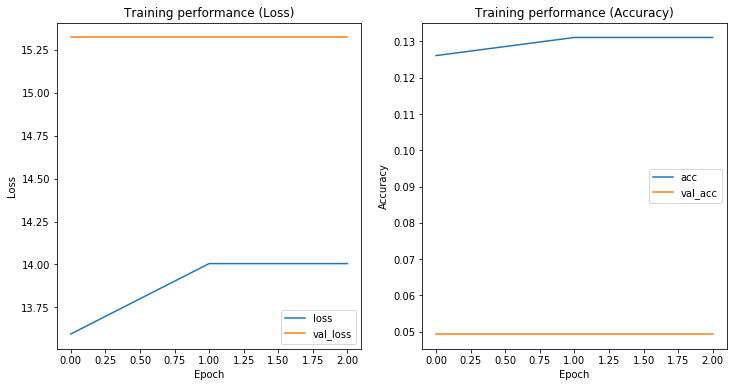

In [10]:
#type1(801) to type1(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y1_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y1_test))

score1 = model.evaluate(X_test, Y1_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

0
4
0
4
0
4
0
1
0
1
0
1
0
2
0
2
0
2
0
11
0
11
0
11
0
9
0
9
0
9
0
0


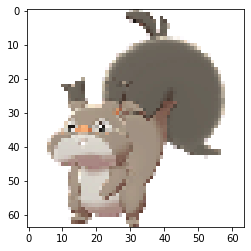

0
0


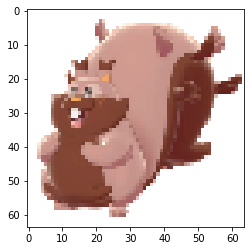

0
15
0
15
0
15
0
0


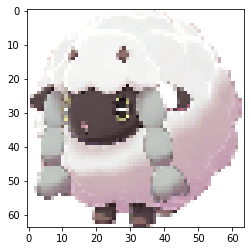

0
0


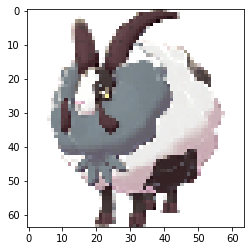

0
2
0
2
0
3
0
3
0
4
0
4
0
1
0
1
0
12
0
12
0
12
0
2
0
2
0
16
0
17
0
17
0
4
0
4
0
4
0
6
0
13
0
15
0
15
0
15
0
10
0
10
0
10
0
16
0
16
0
9
0
3
0
3
0
8
0
8
0
8
0
13
0
13
0
10
0
3
0
6
0
5
0
5
0
6
0
6
0
3
0
5
0
12
0
5
0
16
0
3
0
3
0
2
0
2
0
14
0
14
0
14
0
17
0
6
0
7
4


In [11]:
#結果表示(詳しく)
img_pred2 = model.predict_classes(x_test)

(_, _), (x_test_img2, y1_test_ans2) = (x_train, y1_train),(x_test, y1_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for b in range(81):
    print(img_pred2[b])
    print(y1_test_ans2[b])
    if img_pred2[b] == y1_test_ans2[b]:
        plt.figure()
        plt.imshow(x_test_img2[b])
        plt.show()
        n += 1

print(n)

In [12]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y1_train = np_utils.to_categorical(y1_train, nb_classes)
Y2_test = np_utils.to_categorical(y2_test, nb_classes)

In [13]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K
#image_data_format: 文字列，"channels_last" か "channels_first" のいずれか．Kerasが従うデータのフォーマット規則を指定します． (keras.backend.image_data_format() がこれを返します
#2次元データ (例えば画像) に対しては， "channels_last" は (rows, cols, channels) とみなし，"channels_first" は (channels, rows, cols)とみなします．
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [14]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.15))
model.add(Dense(18, activation='softmax'))

/Users/e175750/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 801 samples, validate on 81 samples
Epoch 1/3
801/801 [==============================] - 89s 111ms/step - loss: 14.9738 - acc: 0.0387 - val_loss: 15.7201 - val_acc: 0.0247
Epoch 2/3
801/801 [==============================] - 111s 138ms/step - loss: 15.4742 - acc: 0.0400 - val_loss: 15.7201 - val_acc: 0.0247
Epoch 3/3
801/801 [==============================] - 124s 155ms/step - loss: 15.4742 - acc: 0.0400 - val_loss: 15.7201 - val_acc: 0.0247
Test score: 15.720117545422212
Test accuracy: 0.024691358024691357


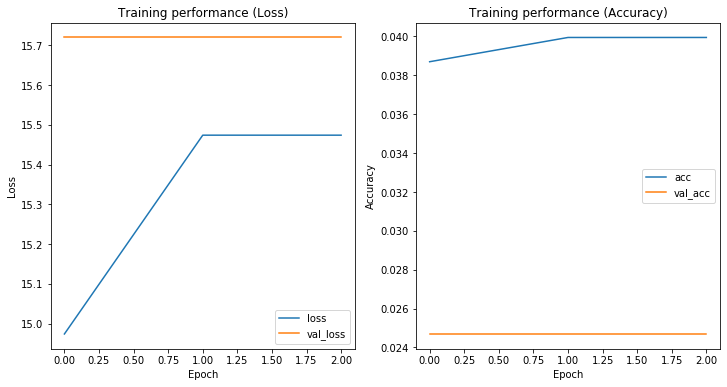

In [15]:
#type1(801) to type2(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y1_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y2_test))

score1 = model.evaluate(X_test, Y2_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

8
4
8
4
8
4
8
1
8
1
8
1
8
2
8
2
8
2
8
11
8
10
8
10
8
9
8
9
8
16
8
0
8
0
8
15
8
15
8
0
8
0
8
0
8
2
8
12
8
3
8
3
8
4
8
4
8
11
8
11
8
12
8
1
8
1
8
2
8
2
8
16
8
17
8
17
8
14
8
14
8
14
8
6
8
13
8
17
8
17
8
17
8
10
8
10
8
17
8
16
8
16
8
2
8
7
8
7
8
8


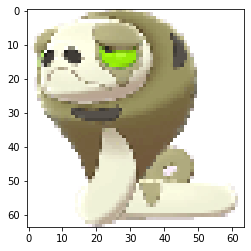

8
8


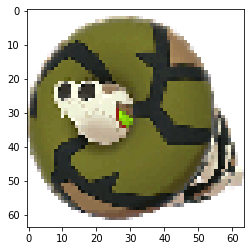

8
13
8
13
8
13
8
0
8
15
8
6
8
11
8
11
8
6
8
6
8
3
8
10
8
12
8
5
8
14
8
14
8
5
8
14
8
5
8
13
8
13
8
13
8
16
8
16
8
14
2


In [16]:
img_pred3 = model.predict_classes(x_test)

# 画像

(_, _), (x_test_img3, y2_test_ans3) = (x_train, y1_train),(x_test, y2_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for c in range(81):
    print(img_pred3[c])
    print(y2_test_ans3[c])
    if img_pred3[c] == y2_test_ans3[c]:
        plt.figure()
        plt.imshow(x_test_img3[c])
        plt.show()
        n += 1

print(n)

In [17]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y2_train = np_utils.to_categorical(y2_train, nb_classes)
Y1_test = np_utils.to_categorical(y1_test, nb_classes)

In [18]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K
#image_data_format: 文字列，"channels_last" か "channels_first" のいずれか．Kerasが従うデータのフォーマット規則を指定します． (keras.backend.image_data_format() がこれを返します
#2次元データ (例えば画像) に対しては， "channels_last" は (rows, cols, channels) とみなし，"channels_first" は (channels, rows, cols)とみなします．
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [19]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.15))
model.add(Dense(18, activation='softmax'))

/Users/e175750/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 801 samples, validate on 81 samples
Epoch 1/3
801/801 [==============================] - 116s 145ms/step - loss: 14.7649 - acc: 0.0512 - val_loss: 15.5211 - val_acc: 0.0370
Epoch 2/3
801/801 [==============================] - 105s 131ms/step - loss: 15.1723 - acc: 0.0587 - val_loss: 15.5211 - val_acc: 0.0370
Epoch 3/3
801/801 [==============================] - 106s 132ms/step - loss: 15.1723 - acc: 0.0587 - val_loss: 15.5211 - val_acc: 0.0370
Test score: 15.52112861915871
Test accuracy: 0.037037037037037035


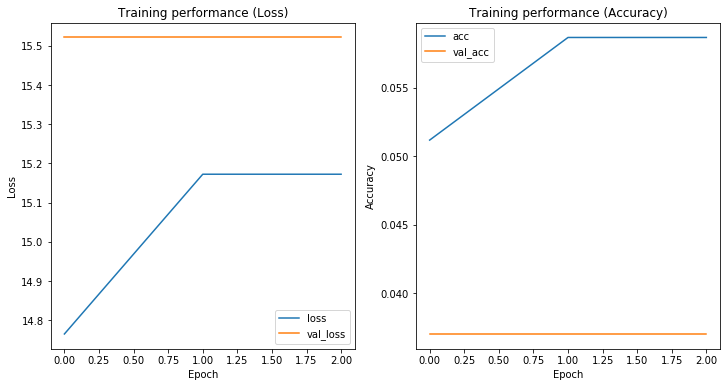

In [20]:
#type2(801) to type1(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y2_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y1_test))

score1 = model.evaluate(X_test, Y1_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

8
4
8
4
8
4
8
1
8
1
8
1
8
2
8
2
8
2
8
11
8
11
8
11
8
9
8
9
8
9
8
0
8
0
8
15
8
15
8
15
8
0
8
0
8
2
8
2
8
3
8
3
8
4
8
4
8
1
8
1
8
12
8
12
8
12
8
2
8
2
8
16
8
17
8
17
8
4
8
4
8
4
8
6
8
13
8
15
8
15
8
15
8
10
8
10
8
10
8
16
8
16
8
9
8
3
8
3
8
8


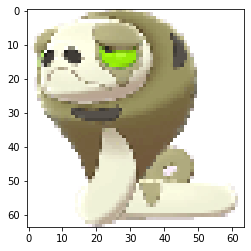

8
8


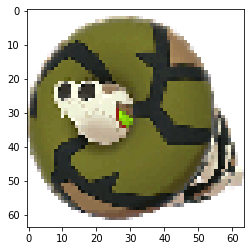

8
8


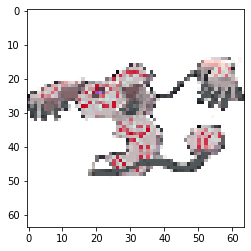

8
13
8
13
8
10
8
3
8
6
8
5
8
5
8
6
8
6
8
3
8
5
8
12
8
5
8
16
8
3
8
3
8
2
8
2
8
14
8
14
8
14
8
17
8
6
8
7
3


In [21]:
img_pred4 = model.predict_classes(x_test)

# 画像

(_, _), (x_test_img4, y1_test_ans4) = (x_train, y2_train),(x_test, y1_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for d in range(81):
    print(img_pred4[d])
    print(y1_test_ans4[d])
    if img_pred4[d] == y1_test_ans4[d]:
        plt.figure()
        plt.imshow(x_test_img4[d])
        plt.show()
        n += 1

print(n)

In [22]:
n = 0
for i in range(81):
    if img_pred1[i] == y2_test_ans1[i] or img_pred2[i] == y1_test_ans2[i] or img_pred3[i] == y2_test_ans3[i] or img_pred4[i] == y1_test_ans4[i]:
        n += 1

print(n)
print(n/81)
        

12
0.14814814814814814


In [1]:
"""
ポケモン画像とタイプデータに対して多クラス分類を行う。
dataset.py からデータをロードし、モデルに合わせて学習データを生成する。
モデルを構築し、学習を行う。結果の可視化を行う。
"""
#TensorFloは、機械学習や深層学習のプログラムを実装する際に使用できるライブラリ
import keras
import tensorflow as tf
import dask
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
import dataset
import dataset2
import random

#データのロード
X,Z = dataset.load_data() #画像データ
Y = dataset2.Data_set() #タイプデータ

import numpy as np
import matplotlib.pyplot as plt

#タイプのラベル
pokemon_labels = np.array([
    "Normal", "Fire", "Water", "Electric", "Grass", "Ice", "Fighting",
    "Poison", "Ground", "Flying", "Psychic", "Bug", "Rock", "Ghost", "Dragon",
    "Dark", "Steel", "Fairy"
])

#X:画像データ
#Y:Type1とType2のデータ

#Type1のみ取得
y1 = Y[0]

#Type2のみ取得
y2 = Y[1]

y1 = list(y1) #シャッフルするために一旦リスト型に変換
y2 = list(y2)
for i in (X, y1, y2):
    random.seed(0)
    random.shuffle(i)

y1 = tuple(y1) #タプル型に戻す
y2 = tuple(y2)

#トレインデータとテストデータの生成
x_train = X[0:801] 
y1_train = y1[0:801]
y2_train = y2[0:801]
x_test = X[801:] 
y1_test = y1[801:] 
y2_test = y2[801:] 

img_rows = 64
img_cols = 64 #モデルに入力する画像の横と縦の幅を64に設定
img_channels = 4 #モデルに入力する画像のチャンネル数
X_train = x_train.astype('float32') / 255.
X_test = x_test.astype('float32') / 255.

nb_classes = 18 # 正解のパターン数

/Users/e175750/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


loading images ... 882/882 done
loading types data ... done


In [2]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y2_train = np_utils.to_categorical(y2_train, nb_classes)
Y2_test = np_utils.to_categorical(y2_test, nb_classes)

In [3]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K
#image_data_format: 文字列，"channels_last" か "channels_first" のいずれか．Kerasが従うデータのフォーマット規則を指定します． (keras.backend.image_data_format() がこれを返します
#2次元データ (例えば画像) に対しては， "channels_last" は (rows, cols, channels) とみなし，"channels_first" は (channels, rows, cols)とみなします．
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [ ]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(18, activation='softmax'))

In [ ]:
#type2(801) to type2(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y2_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y2_test))

score1 = model.evaluate(X_test, Y2_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

/Users/e175750/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 801 samples, validate on 81 samples
Epoch 1/3
801/801 [==============================] - 85s 106ms/step - loss: 14.5222 - acc: 0.0687 - val_loss: 15.7201 - val_acc: 0.0247
Epoch 2/3
801/801 [==============================] - 93s 117ms/step - loss: 14.9107 - acc: 0.0749 - val_loss: 15.7201 - val_acc: 0.0247
Epoch 3/3
 96/801 [==>...........................] - ETA: 1:32 - loss: 14.7749 - acc: 0.0833

In [ ]:
import matplotlib.pyplot as plt

img_pred5 = model.predict_classes(x_test)

(_, _), (x_test_img5, y2_test_ans5) = (x_train, y2_train),(x_test, y2_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for e in range(81):
    print(img_pred5[e])
    print(y2_test_ans5[e])
    if img_pred5[e] == y2_test_ans5[e]:
        plt.figure()
        plt.imshow(x_test_img5[e])
        plt.show()
        n += 1

print(n)

In [ ]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y1_train = np_utils.to_categorical(y1_train, nb_classes)
Y1_test = np_utils.to_categorical(y1_test, nb_classes)

In [ ]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K
#image_data_format: 文字列，"channels_last" か "channels_first" のいずれか．Kerasが従うデータのフォーマット規則を指定します． (keras.backend.image_data_format() がこれを返します
#2次元データ (例えば画像) に対しては， "channels_last" は (rows, cols, channels) とみなし，"channels_first" は (channels, rows, cols)とみなします．
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [ ]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(18, activation='softmax'))

In [ ]:
#type1(801) to type1(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y1_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y1_test))

score1 = model.evaluate(X_test, Y1_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

In [ ]:
#結果表示(詳しく)
img_pred6 = model.predict_classes(x_test)

(_, _), (x_test_img6, y1_test_ans6) = (x_train, y1_train),(x_test, y1_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for f in range(81):
    print(img_pred6[f])
    print(y1_test_ans6[f])
    if img_pred6[f] == y1_test_ans6[f]:
        plt.figure()
        plt.imshow(x_test_img6[f])
        plt.show()
        n += 1

print(n)

In [ ]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y1_train = np_utils.to_categorical(y1_train, nb_classes)
Y2_test = np_utils.to_categorical(y2_test, nb_classes)

In [ ]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K
#image_data_format: 文字列，"channels_last" か "channels_first" のいずれか．Kerasが従うデータのフォーマット規則を指定します． (keras.backend.image_data_format() がこれを返します
#2次元データ (例えば画像) に対しては， "channels_last" は (rows, cols, channels) とみなし，"channels_first" は (channels, rows, cols)とみなします．
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [ ]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(18, activation='softmax'))

In [ ]:
#type1(801) to type2(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y1_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y2_test))

score1 = model.evaluate(X_test, Y2_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

In [ ]:
img_pred7 = model.predict_classes(x_test)

# 画像

(_, _), (x_test_img7, y2_test_ans7) = (x_train, y1_train),(x_test, y2_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for g in range(81):
    print(img_pred7[g])
    print(y2_test_ans7[g])
    if img_pred7[g] == y2_test_ans7[g]:
        plt.figure()
        plt.imshow(x_test_img7[g])
        plt.show()
        n += 1

print(n)

In [ ]:
from keras.utils import np_utils
# 正解ラベルをOne-Hot表現に変換
Y2_train = np_utils.to_categorical(y2_train, nb_classes)
Y1_test = np_utils.to_categorical(y1_test, nb_classes)

In [ ]:
# backendの違いによる次元数の入力型の調整
from keras import backend as K
#image_data_format: 文字列，"channels_last" か "channels_first" のいずれか．Kerasが従うデータのフォーマット規則を指定します． (keras.backend.image_data_format() がこれを返します
#2次元データ (例えば画像) に対しては， "channels_last" は (rows, cols, channels) とみなし，"channels_first" は (channels, rows, cols)とみなします．
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [ ]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
#モデルの構築
model = Sequential()
#Sequentialはただ層を積み上げるだけの単純なモデル。
model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation="relu",input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(18, activation='softmax'))

In [ ]:
#type2(801) to type1(81)
from keras.optimizers import SGD, Adadelta, Adam, RMSprop  # 最適化

model.compile(
    loss="categorical_crossentropy",  # 誤差(損失)関数
    optimizer="Adamax",  # 最適化関数
    metrics=["accuracy"]  # 評価指標
)
import time
history = model.fit(
    X_train,
    Y2_train,
    batch_size=32,  # 512個ランダムに得る
    nb_epoch=3,  # 試行回数
    verbose=1,
    validation_data=(X_test, Y1_test))

score1 = model.evaluate(X_test, Y1_test, verbose=0)
print('Test score:', score1[0])  # 損失関数の値
print('Test accuracy:', score1[1])  # 精度(98%強)


#結果の可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

In [ ]:
img_pred8 = model.predict_classes(x_test)

(_, _), (x_test_img8, y1_test_ans8) = (x_train, y2_train),(x_test, y1_test)  
#(x_test_img, y2_test_ans) = (x_test, y2_test)
n=0
for h in range(81):
    print(img_pred8[h])
    print(y1_test_ans8[h])
    if img_pred8[h] == y1_test_ans8[h]:
        plt.figure()
        plt.imshow(x_test_img8[h])
        plt.show()
        n += 1

print(n)

In [ ]:
n = 0
for i in range(81):
    if img_pred5[i] == y2_test_ans5[i] or img_pred6[i] == y1_test_ans6[i] or img_pred7[i] == y2_test_ans7[i] or img_pred8[i] == y1_test_ans8[i]:
        n += 1

print(n)
print(n/81)

In [ ]:
#以下は見なくていい(使う場面があったら使う)

435


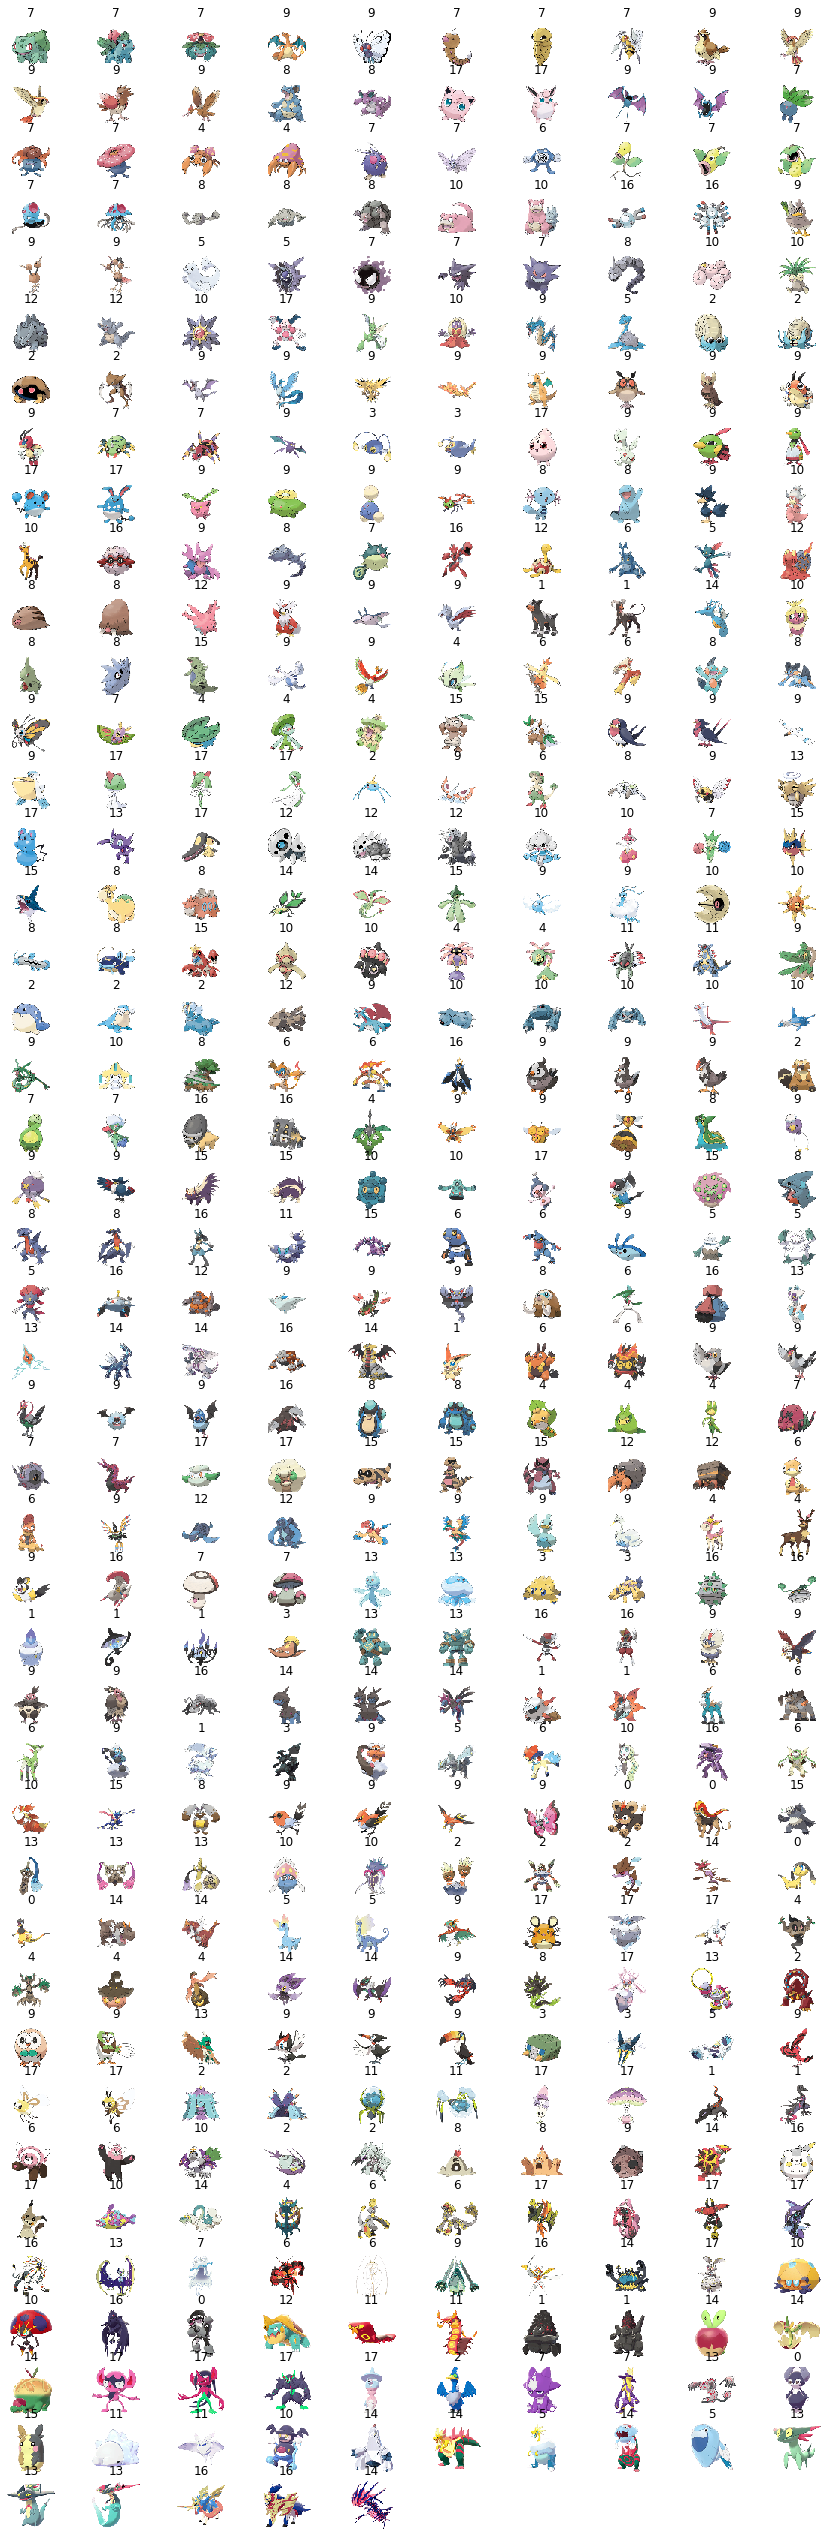

435
435
400
400
35
35


In [2]:
#typeを二つ持っているポケモンの選別(type2)
type_2_y = []
type_2_x = []
for i in range(882):
    if (y1[i] != y2[i]):
        type_2_y.append(y2[i])
        type_2_x.append(X[i])
        
print(len(type_2_y))

fig = plt.figure(figsize=(15, 85), facecolor="w")
for i, p in enumerate(type_2_y, 1):
    ax = fig.add_subplot(81, 10, i)
    ax.imshow(type_2_x[i-1])
    ax.set_axis_off()
    ax.set_title(type_2_y[i-1])

plt.show()


type_2_y = np.array(type_2_y)
type_2_x = np.array(type_2_x)
type_2_x = type_2_x.astype('float32') / 255.
print(len(type_2_x))
print(len(type_2_y))

type_2_x_train = type_2_x[0:400]
type_2_y_train = type_2_y[0:400]
type_2_x_test = type_2_x[400:]
type_2_y_test = type_2_y[400:]

#タイプを二つ持っているポケモンのトレーニングデータとテストデータ(type2)
print(len(type_2_x_train))
print(len(type_2_y_train))
print(len(type_2_x_test))
print(len(type_2_y_test))

0.2500000001490116
